# CO2 emissions prediction for cars sold in France

- Import libraries

In [1]:
# libraries used for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# librairies used for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_text
import xgboost as xgb

# utils
import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# path for Linux OS
INPUT_DATASET = "../data/dataset.csv"

# path for Windows OS
# INPUT_DATASET = "data/dataset.csv"

In [3]:
def parse_xgb_output(output):
    results = []
    tree=[]
    mse_train = []
    mse_val = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])
        
        results.append((it, train, val))

    columns = ["num_iter", "train_mse", "val_mse"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

- Import data

In [4]:
df = pd.read_csv(INPUT_DATASET)
df.head()

,make,model,energy,car_classification,cylinder_capacity,market_category,tax_horsepower,max_horsepower,electrical_nominal_power,weight,...,bonus_malus,low_speed_fuel_consumption,average_speed_fuel_consumption,high_speed_fuel_consumption,very_high_speed_fuel_consumption,combined_speed_fuel_consumption,elect_conso,electrical_autonomy,city_electrical_autonomy,co2_emission
0,renault,kangoo,gasoline,leisure_activity_vehicle,1332,low,7,96.0,NaN,1519,...,malus,8.7405,6.7880,6.188,7.9175,7.2635,NaN,NaN,NaN,167.272
1,mazda,mx-30,electric,crossover_suv,0,low,6,NaN,80.9,1645,...,bonus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ds,7_crossback,phev_gas,crossover_suv,1598,average_high,10,133.0,30.0,1760,...,neutral,NaN,NaN,NaN,NaN,1.5340,162.5,58.5,67.5,NaN
3,renault,austral,hev_gas,crossover_suv,1199,average_high,7,96.0,0.0,1421,...,neutral,6.5805,5.0200,4.834,5.9555,5.5025,NaN,NaN,NaN,126.073
4,b.m.w.,218,gasoline,compact_multi_purpose_vehicle,1499,average_low,7,100.0,NaN,1470,...,malus,8.9420,6.6295,5.637,6.4505,6.5680,NaN,NaN,NaN,155.826


The dataset used here is a simplified version of the original, available on the [ADEME](https://www.ademe.fr/en/frontpage/) (French Agency for Ecological Transition) website. To understand how the simplification was achieved, notebook *001.preparation_translation* presents all the steps involved. This notebook also includes a translation to help non-French speakers understand the different variables.

## 1) Data Preparation

Let's take a look to our data.

In [5]:
# removing electric vehicles because they don't produce CO2
df = df[df["energy"] != 'electric']

In [6]:
df.shape

(7409, 23)

In [7]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7409   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %   ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ cylinder_capacity       │     0 │      0 │   1800 │    610 │   880 │  1500 │  2000 │  2000 │ 6700 │  ▇▆▁   │  │
│ │ tax_horsepower          │     0 │      0 │     10 │    7.8 │     4 │     6 │     8 │    10 │   91 │   ▇▁   │  │
│ │ max_horsepower          │     0 │      0 │    130 │     66 │    48 │    92 │   110 │   140 │  610 │  ▇▂▁   │  │
│ │ electrical_nominal_powe │  4925 │  66.47 │     20 │     27 │     0 │     0 │     8 │    30 │  140 │  ▇▁▂▁  │  │
│ │ r                       │       │        │        │        │       │       │       │       │      │        │  │
│ │ weight                  │     0 │      0 │   1600 │    330 │   840 │  1300 │  1500 │  1800 │ 2700 │ ▂▇▆▃▁  │  │
│ │ weight_horsepower_ratio │     0 │      0 │  0.082 │  0.032 │  0.04 │  0.06 │  0.08 │  0.09 │ 0.37 │   ▇▁   │  │
│ │ no_gears                │     0 │      0 │    6.9 │    1.6 │     0 │     6 │     7 │     8 │    9 │     ▇▆ │  │
│ │ low_speed_fuel_consumpt │   719 │    9.7 │      8 │    2.2 │   3.2 │   6.7 │   7.8 │   8.9 │   30 │   ▇▇   │  │
│ │ ion                     │       │        │        │        │       │       │       │       │      │        │  │
│ │ average_speed_fuel_cons │   719 │    9.7 │    6.1 │    1.3 │   3.3 │   5.2 │   5.9 │   6.7 │   18 │  ▆▇▁   │  │
│ │ umption                 │       │        │        │        │       │       │       │       │      │        │  │
│ │ high_speed_fuel_consump │   719 │    9.7 │    5.4 │      1 │   3.7 │   4.7 │   5.3 │   5.8 │   14 │  ▇▆▁   │  │
│ │ tion                    │       │        │        │        │       │       │       │       │      │        │  │
│ │ very_high_speed_fuel_co │   719 │    9.7 │    6.5 │    1.1 │   4.2 │   5.7 │   6.3 │     7 │   14 │  ▅▇▂   │  │
│ │ nsumption               │       │        │        │        │       │       │       │       │      │        │  │
│ │ combined_speed_fuel_con │   125 │   1.69 │    5.9 │    1.7 │  0.56 │   5.2 │     6 │   6.8 │   17 │  ▁▆▇   │  │
│ │ sumption                │       │        │        │        │       │       │       │       │      │        │  │
│ │ elect_conso             │  6815 │  91.98 │    200 │     40 │   130 │   160 │   190 │   240 │  290 │ ▆▇▅▃▇▁ │  │
│ │ electrical_autonomy     │  6815 │  91.98 │     62 │     18 │    40 │    48 │    56 │    74 │  110 │ ▇▅▂▂▁▁ │  │
│ │ city_electrical_autonom │  6815 │  91.98 │     68 │     20 │    41 │    52 │    61 │    87 │  120 │ ▇▅▃▃▃▁ │  │
│ │ y                       │       │        │        │ 

The dataset contains 7679 rows and 23 columns. Of these 23 columns, 7 represent categorical variables and the rest contain quantitative variables.
As far as missing values are concerned, only numerical variables have missing values. Two strategies were chosen to fill them:
- For variables relating to electricity consumption, missing values will be filled in with 0. 
- For other variables, missing values will be filled by the median.

In [8]:
# create list with categorical variables
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [9]:
# create list with numerical variables
# target (co2_emission) is removed
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'co2_emission'

- Dealing with missing values

In [10]:
# fill variables about electric consumption
df["electrical_autonomy"] = df["electrical_autonomy"].fillna(0)
df["electrical_nominal_power"] = df["electrical_nominal_power"].fillna(0)
df["elect_conso"] = df["elect_conso"].fillna(0)
df["city_electrical_autonomy"] = df["city_electrical_autonomy"].fillna(0)

In [11]:
# fill other numerical variables
for c in numerical:
    df[c] = df[c].fillna(df[c].median())

In [12]:
# fill target variable
df["co2_emission"] = df["co2_emission"].fillna(df["co2_emission"].median())

In [13]:
# verify if missing values are processed
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7409   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ cylinder_capacity        │   0 │     0 │    1800 │    610 │   880 │  1500 │  2000 │  2000 │  6700 │  ▇▆▁   │  │
│ │ tax_horsepower           │   0 │     0 │      10 │    7.8 │     4 │     6 │     8 │    10 │    91 │   ▇▁   │  │
│ │ max_horsepower           │   0 │     0 │     130 │     66 │    48 │    92 │   110 │   140 │   610 │  ▇▂▁   │  │
│ │ electrical_nominal_power │   0 │     0 │     6.8 │     18 │     0 │     0 │     0 │     0 │   140 │   ▇    │  │
│ │ weight                   │   0 │     0 │    1600 │    330 │   840 │  1300 │  1500 │  1800 │  2700 │ ▂▇▆▃▁  │  │
│ │ weight_horsepower_ratio  │   0 │     0 │   0.082 │  0.032 │  0.04 │  0.06 │  0.08 │  0.09 │  0.37 │   ▇▁   │  │
│ │ no_gears                 │   0 │     0 │     6.9 │    1.6 │     0 │     6 │     7 │     8 │     9 │     ▇▆ │  │
│ │ low_speed_fuel_consumpti │   0 │     0 │       8 │    2.1 │   3.2 │   6.8 │   7.8 │   8.7 │    30 │   ▆▇   │  │
│ │ on                       │     │       │         │        │       │       │       │       │       │        │  │
│ │ average_speed_fuel_consu │   0 │     0 │     6.1 │    1.2 │   3.3 │   5.3 │   5.9 │   6.6 │    18 │   ▅▇   │  │
│ │ mption                   │     │       │         │        │       │       │       │       │       │        │  │
│ │ high_speed_fuel_consumpt │   0 │     0 │     5.4 │   0.98 │   3.7 │   4.8 │   5.3 │   5.8 │    14 │   ▇▅   │  │
│ │ ion                      │     │       │         │        │       │       │       │       │       │        │  │
│ │ very_high_speed_fuel_con │   0 │     0 │     6.4 │    1.1 │   4.2 │   5.7 │   6.3 │   6.9 │    14 │  ▅▇▂   │  │
│ │ sumption                 │     │       │         │        │       │       │       │       │       │        │  │
│ │ combined_speed_fuel_cons │   0 │     0 │     5.9 │    1.7 │  0.56 │   5.3 │     6 │   6.7 │    17 │  ▁▆▇   │  │
│ │ umption                  │     │       │         │        │       │       │       │       │       │        │  │
│ │ elect_conso              │   0 │     0 │      16 │     55 │     0 │     0 │     0 │     0 │   290 │   ▇    │  │
│ │ electrical_autonomy      │   0 │     0 │       5 │     18 │     0 │     0 │     0 │     0 │   110 │   ▇    │  │
│ │ city_electrical_autonomy │   0 │     0 │     5.5 │     19 │     0 │     0 │     0 │     0 │   120 │   ▇    │  │
│ │ co2_emission             │   0 │     0 │     150 │     29 │    93 │   140 │   150 │   160 │   410 │  ▆▇▁   │  │
│ └──────────────────────────┴─────┴───────┴─────────┴──

Missing values are processed. Exploratory analysis can be performed.

## 2) Exploratory Data Analysis

EDA consists of two parts.

In the first part, each variable is analyzed individually to get an idea of its behavior on its own, without interaction. In the second part, a bivariate analysis is performed. The aim of this analysis is to understand the interaction between the target (CO2 emissions) and the different variables.

### a) Univariate Analysis

#### 1. Target

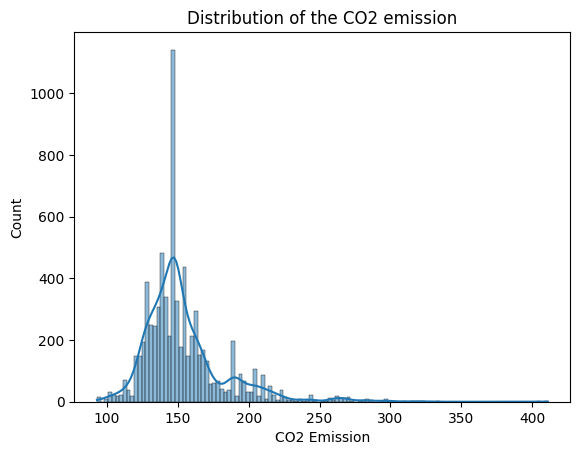

In [14]:
sns.histplot(
    data = df,
    x = "co2_emission",
    kde=True
)
plt.xlabel("CO2 Emission")
plt.title("Distribution of the CO2 emission")
plt.show()

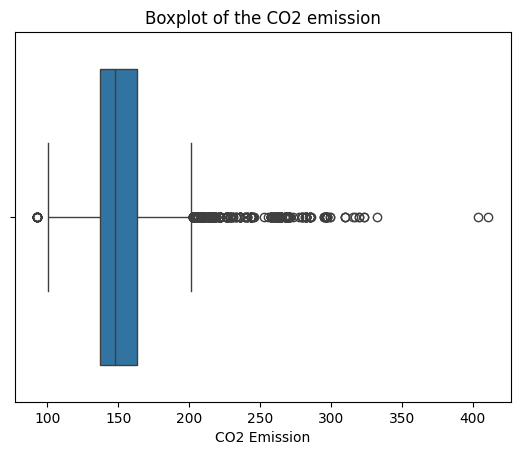

In [15]:
sns.boxplot(
    x="co2_emission",
    data=df
)
plt.xlabel("CO2 Emission")
plt.title('Boxplot of the CO2 emission')
plt.show()

In [16]:
df["co2_emission"].describe()

count    7409.000000
mean      153.970594
std        29.283719
min        92.947000
25%       137.293000
50%       147.635000
75%       162.945000
max       411.010000
Name: co2_emission, dtype: float64

In preparation for a future linear regression analysis, it's important to address the asymmetry in the distribution of the target variable. Linear regression models are particularly sensitive to such imbalances. To mitigate potential issues during model training, we employ a logarithmic transformation on the target variable. This transformation is performed using Numpy's log1p function, which cleverly adds 1 to the variable before applying the logarithmic operation. This addition serves a crucial purpose by preventing the occurrence of a logarithm of zero, which would otherwise result in an undefined value.

```np.log1p(x)``` = $1 + log(x)$

In [17]:
# log transformation
df["co2_emission"] = np.log1p(df["co2_emission"])

#### 2. Features

##### Categorical features

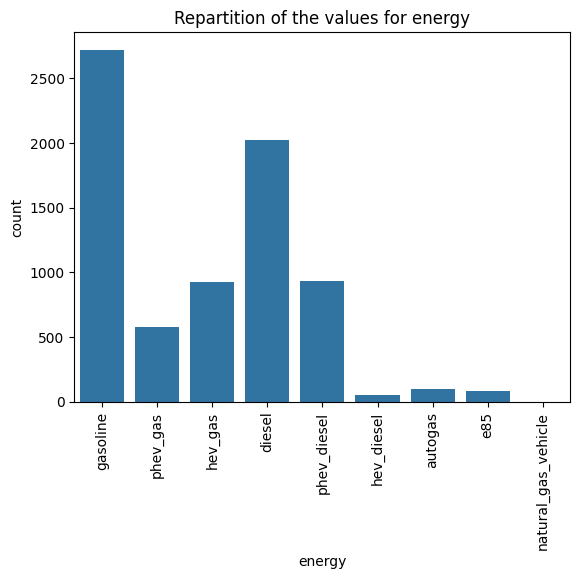

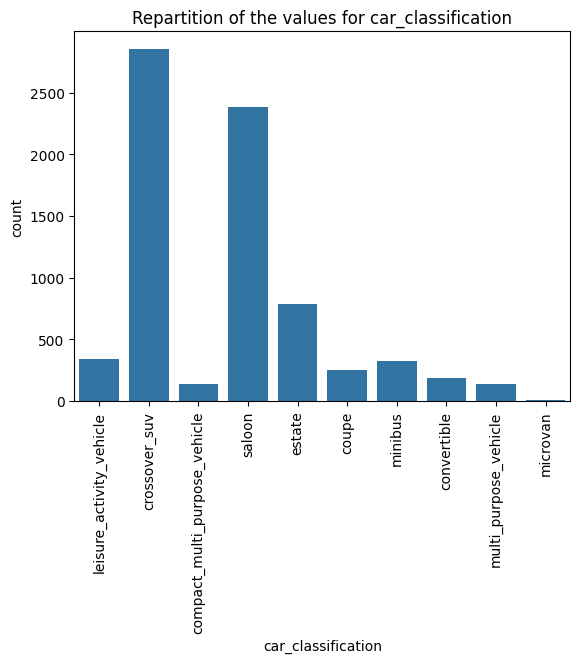

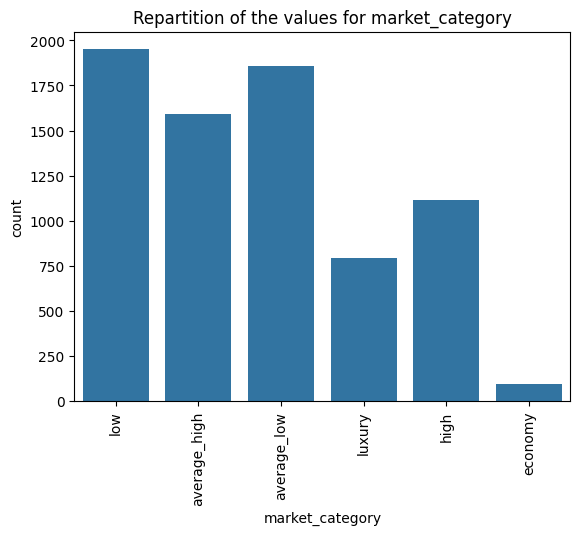

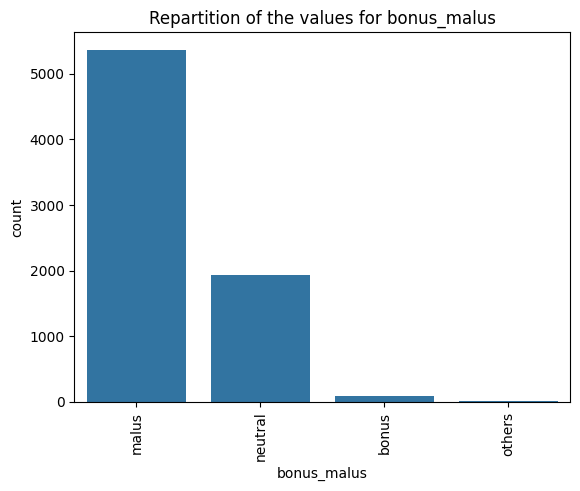

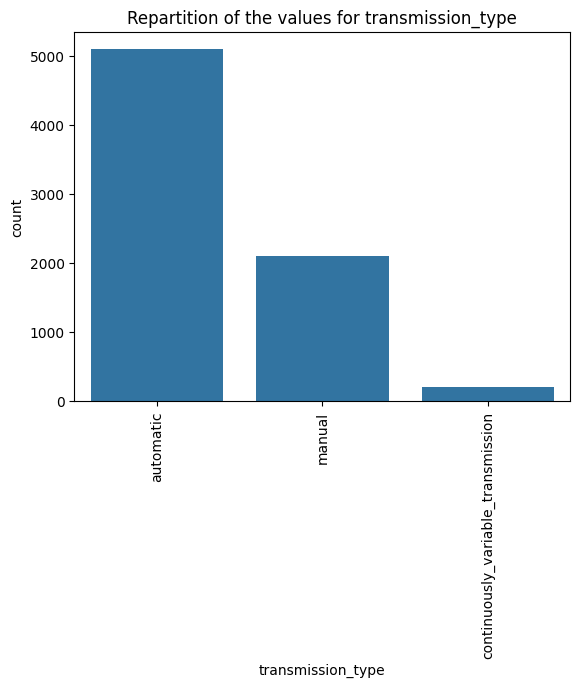

In [18]:
for col in ['energy', 'car_classification', 'market_category', 'bonus_malus', "transmission_type"]:
    sns.countplot(
        x=col,
        data=df
        )
    plt.title(f"Repartition of the values for {col}")
    plt.xticks(rotation=90)
    plt.show()

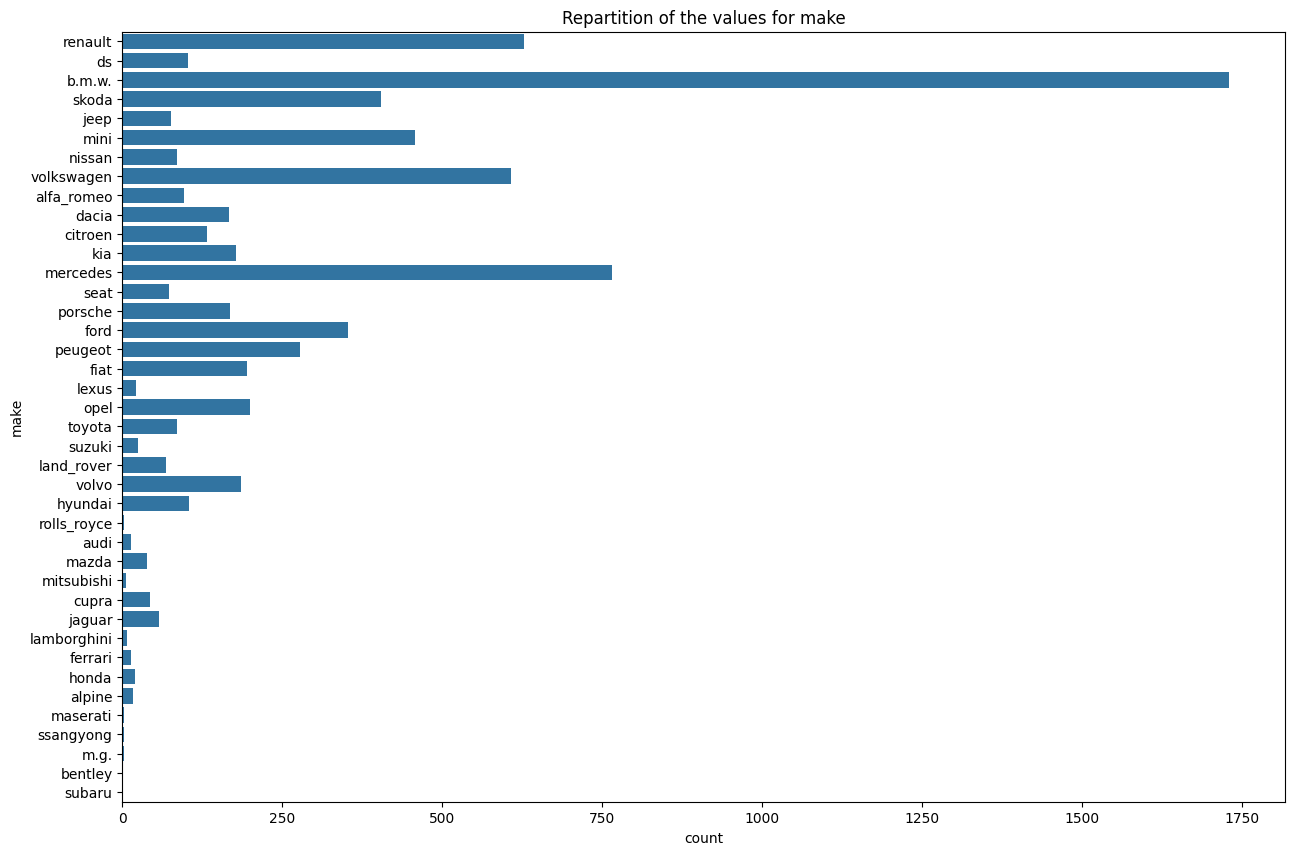

In [19]:
plt.figure(figsize=(15,10))

sns.countplot(
    y="make",
    data=df
)
plt.title(f"Repartition of the values for make")
plt.show()

##### Numerical features

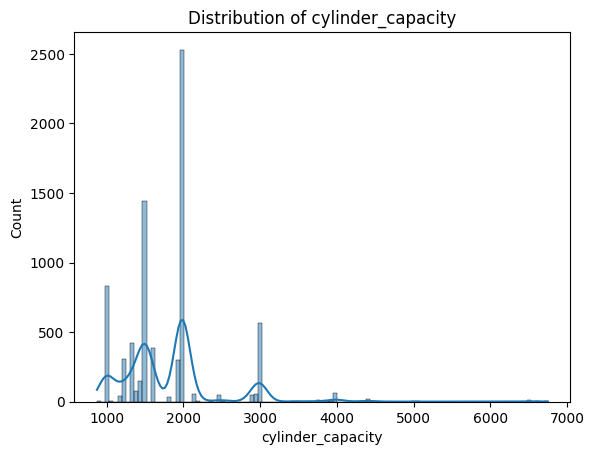

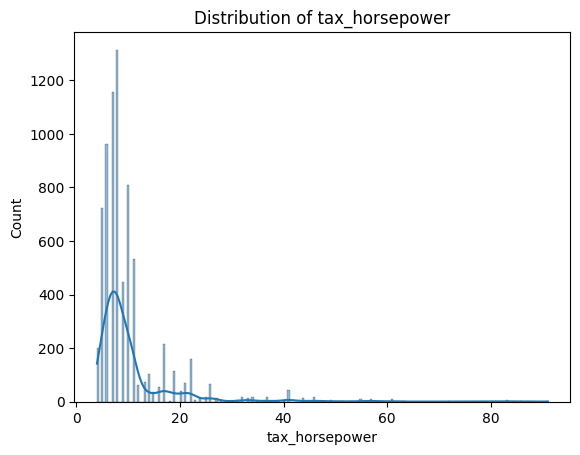

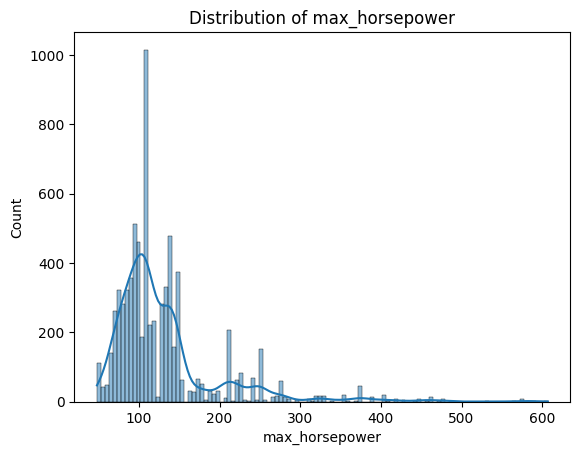

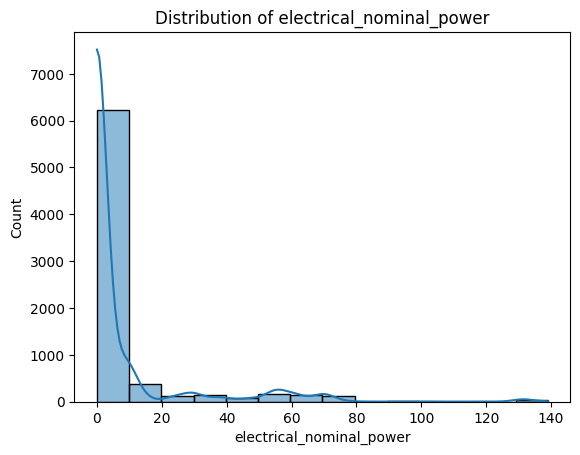

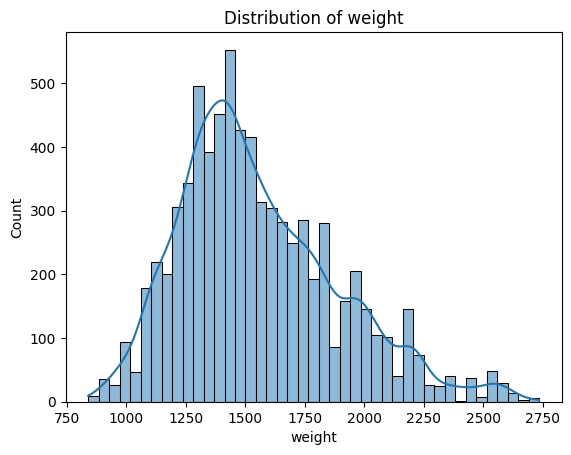

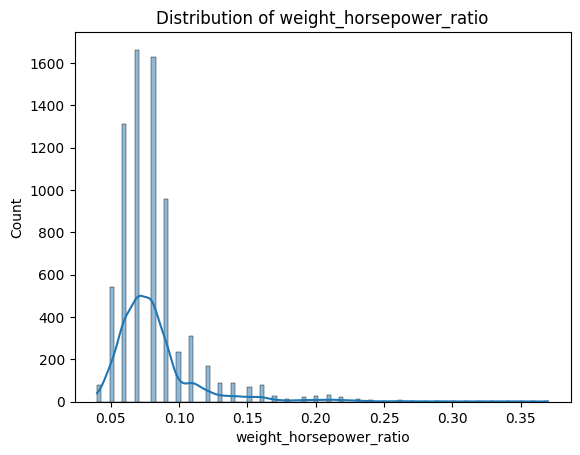

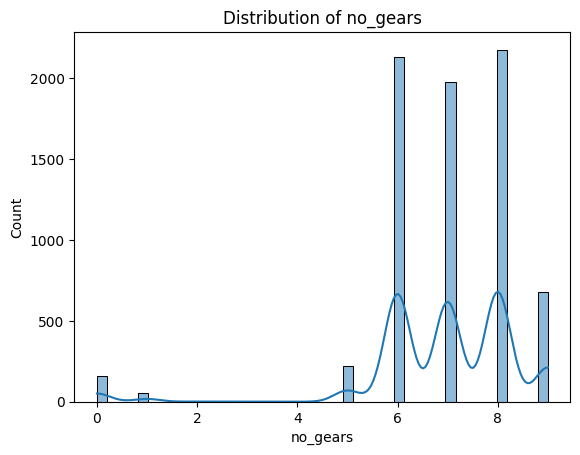

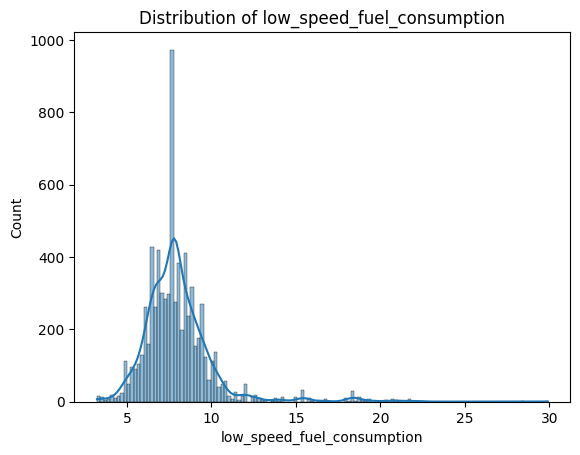

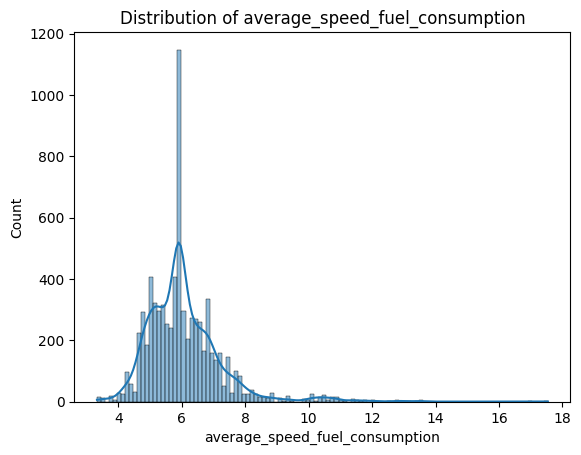

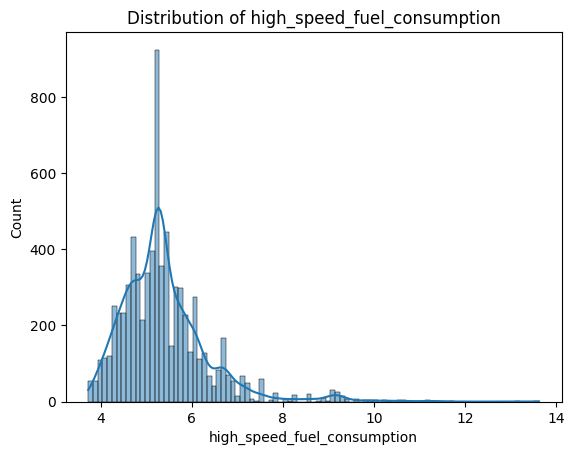

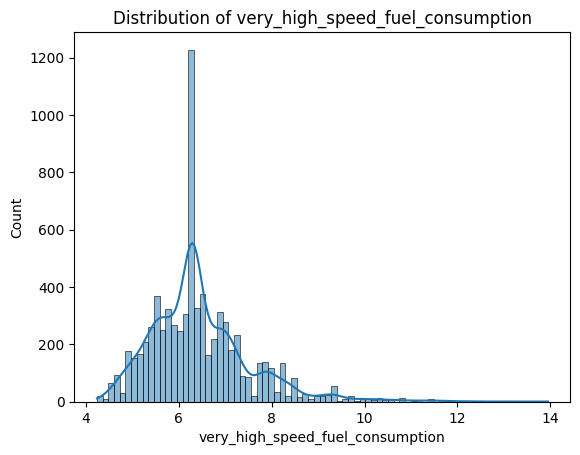

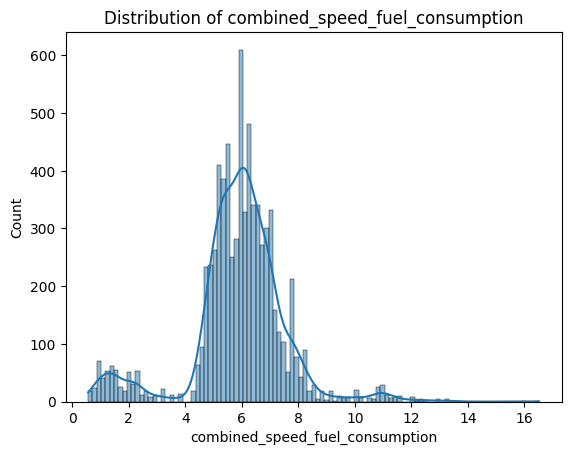

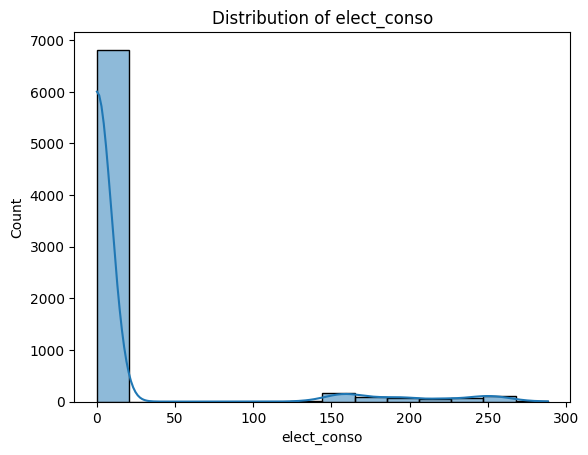

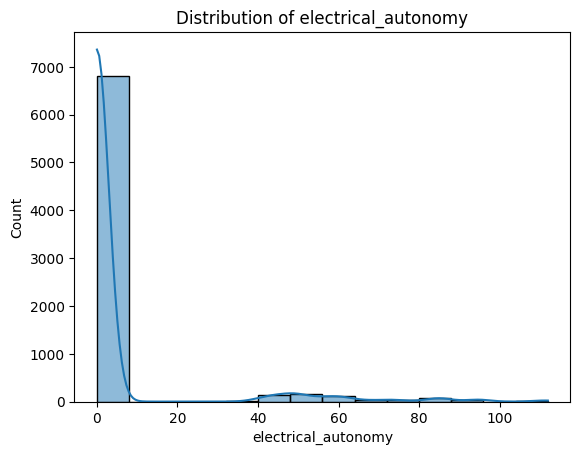

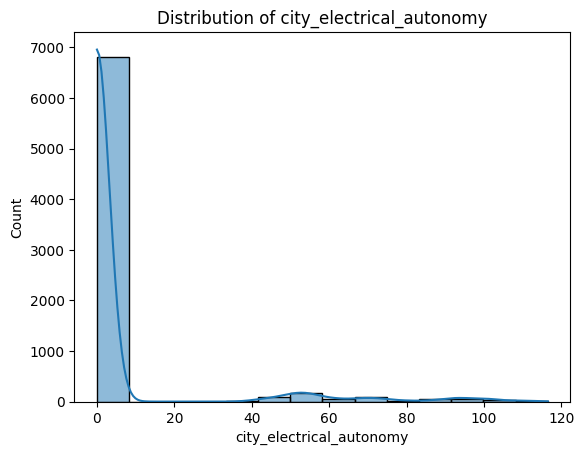

In [20]:
for col in numerical:
    sns.histplot(
        x=col,
        data=df,
        kde=True
        )
    plt.title(f"Distribution of {col}")
    plt.show()

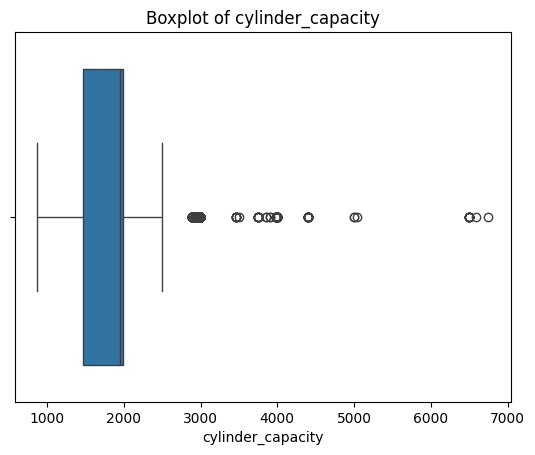

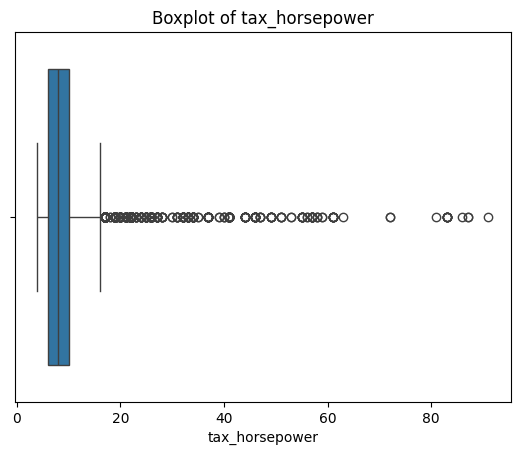

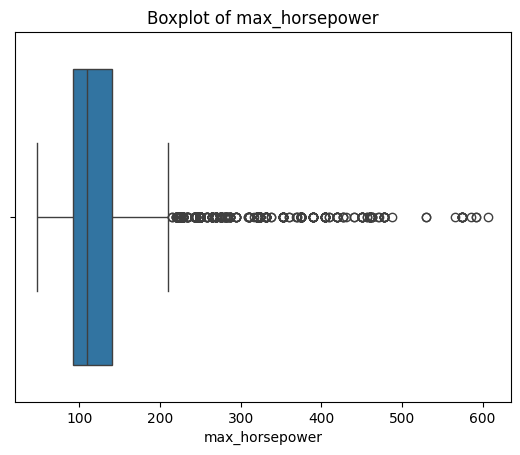

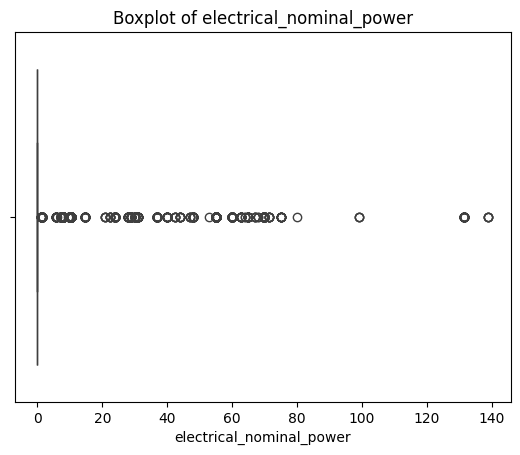

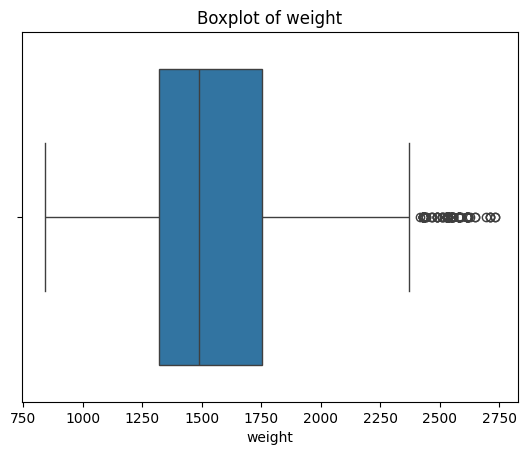

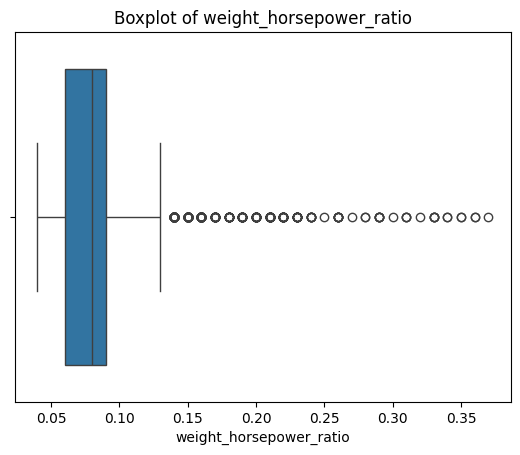

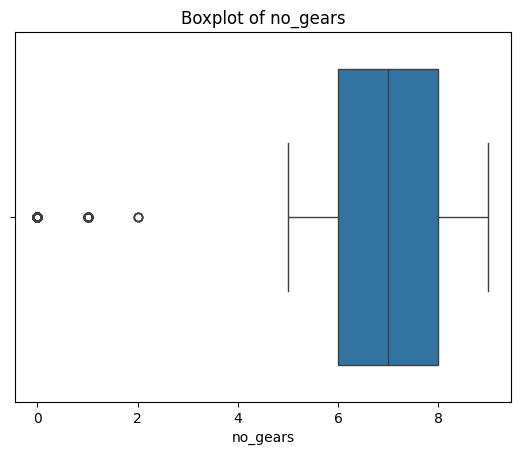

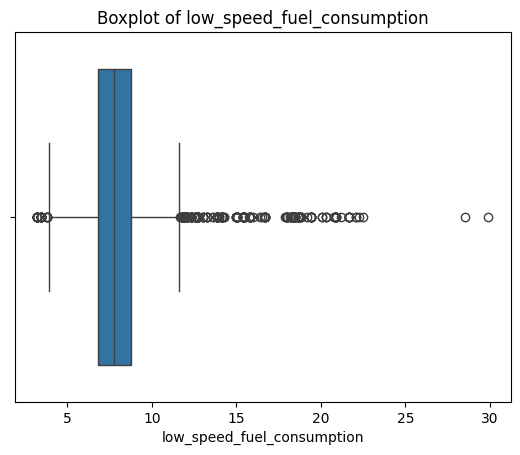

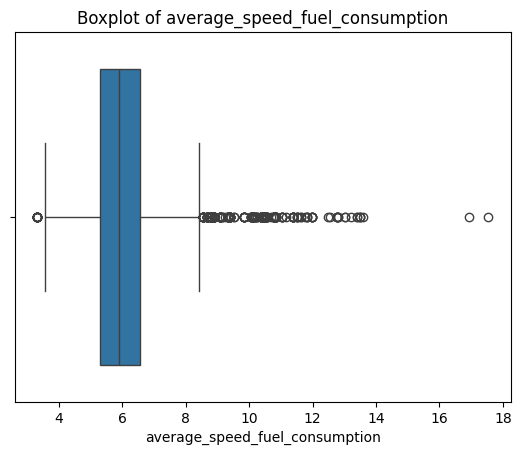

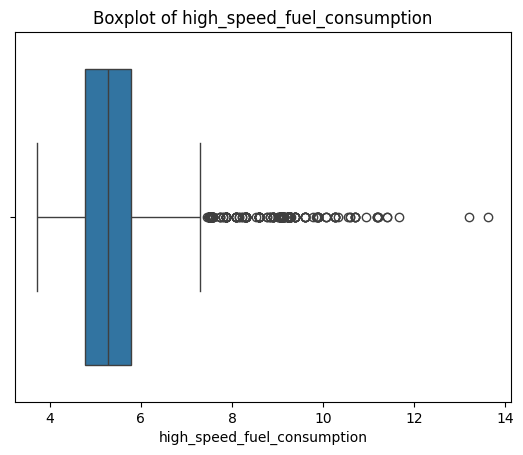

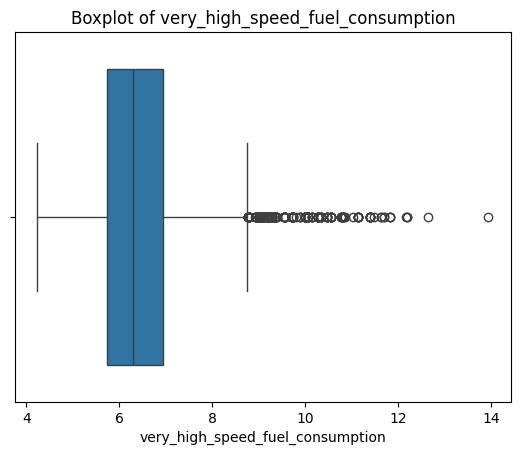

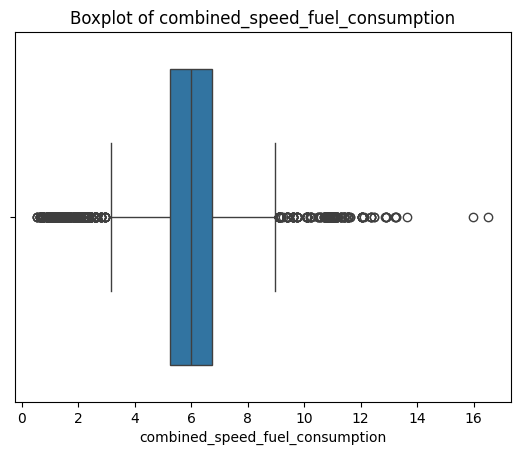

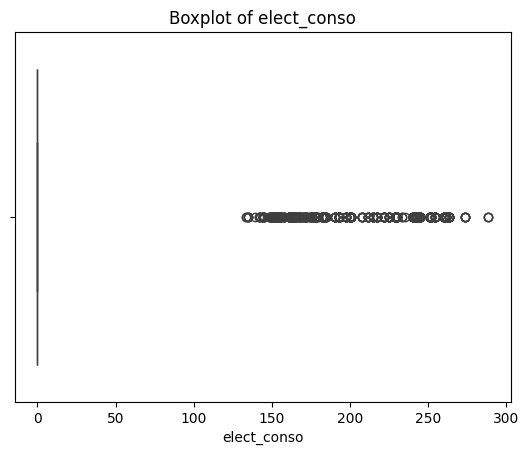

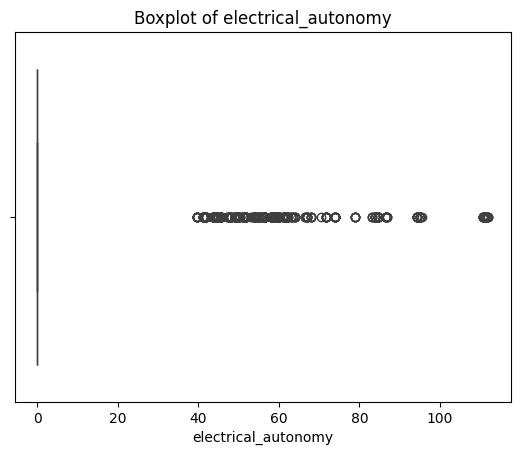

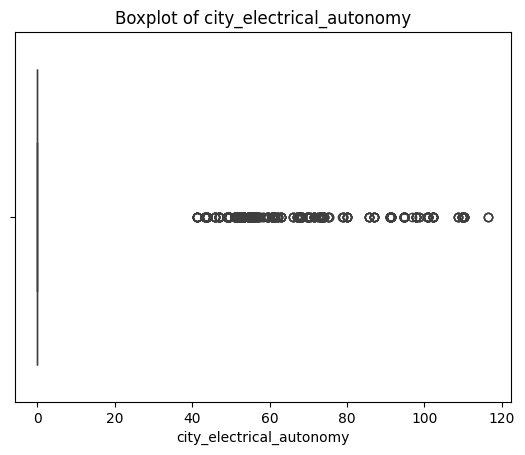

In [21]:
for col in numerical:
    sns.boxplot(
        x = col,
        data = df
        )
    plt.title(f"Boxplot of {col}")
    plt.show()

In [22]:
df.describe()

,cylinder_capacity,tax_horsepower,max_horsepower,electrical_nominal_power,weight,weight_horsepower_ratio,no_gears,low_speed_fuel_consumption,average_speed_fuel_consumption,high_speed_fuel_consumption,very_high_speed_fuel_consumption,combined_speed_fuel_consumption,elect_conso,electrical_autonomy,city_electrical_autonomy,co2_emission
count,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000
mean,1796.202322,10.229856,130.021055,6.757998,1555.344986,0.082061,6.928195,7.994275,6.059746,5.394037,6.447842,5.898809,16.028831,4.950236,5.455918,5.027846
std,609.909070,7.806961,66.386992,18.413563,333.232021,0.031618,1.553918,2.128792,1.192675,0.977377,1.080364,1.704561,55.477397,17.564573,19.324330,0.170188
min,875.000000,4.000000,48.000000,0.000000,840.000000,0.040000,0.000000,3.219000,3.327000,3.726000,4.238500,0.562000,0.000000,0.000000,0.000000,4.542731
25%,1469.000000,6.000000,91.900000,0.000000,1320.000000,0.060000,6.000000,6.807000,5.308500,4.761000,5.733500,5.256000,0.000000,0.000000,0.000000,4.929375
50%,1950.000000,8.000000,110.000000,0.000000,1490.000000,0.080000,7.000000,7.765000,5.912500,5.267500,6.296000,5.987000,0.000000,0.000000,0.000000,5.001494
75%,1995.000000,10.000000,140.000000,0.000000,1755.000000,0.090000,8.000000,8.740500,6.555000,5.778500,6.940000,6.746500,0.000000,0.000000,0.000000,5.099531
max,6749.000000,91.000000,607.000000,139.000000,2735.000000,0.370000,9.000000,29.914500,17.541500,13.632000,13.947000,16.521500,288.500000,112.000000,116.500000,6.021048


### b) Multivariate analysis

#### 1. Relation between target and numerical variables

In [23]:
numerical.append("co2_emission")

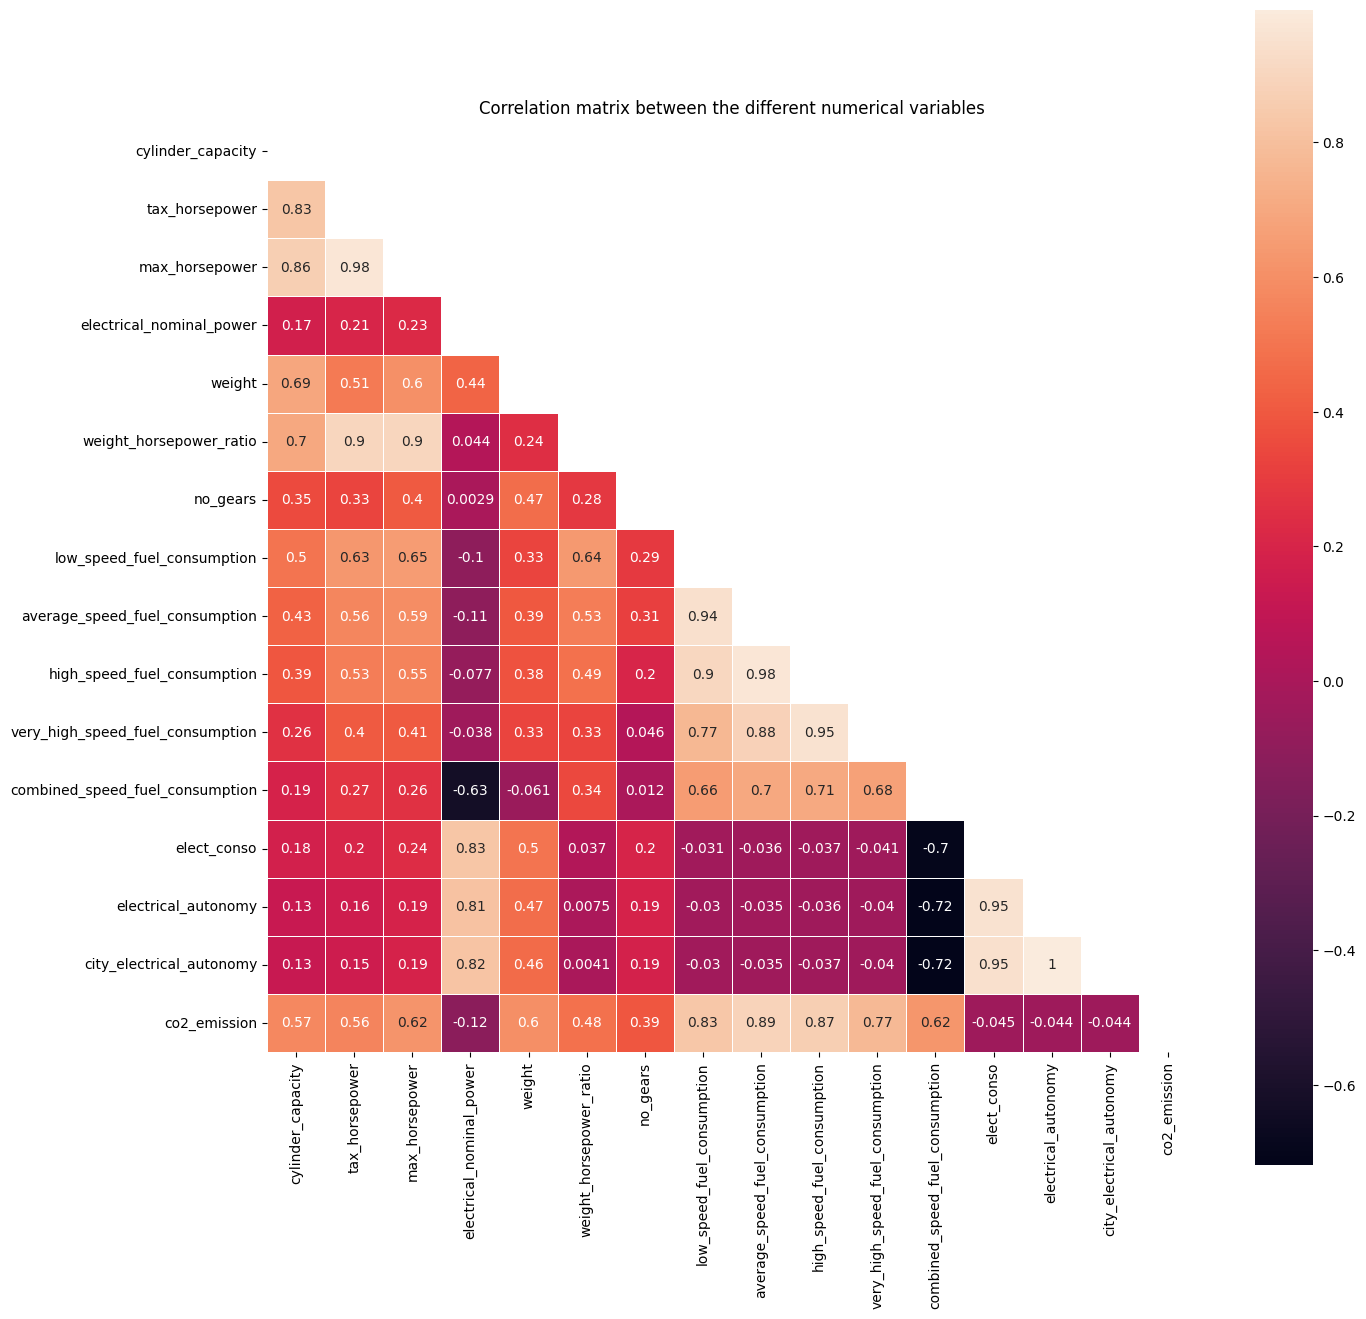

In [24]:
corr_matrix = df[numerical].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            linewidths=.5, 
            annot=True, 
            cbar=True, 
            square=True)
plt.title("Correlation matrix between the different numerical variables")
plt.show()

In [25]:
# removing variables with poor correlation coefficient
del df["electrical_nominal_power"]
del df["elect_conso"]
del df["electrical_autonomy"]
del df["city_electrical_autonomy"]

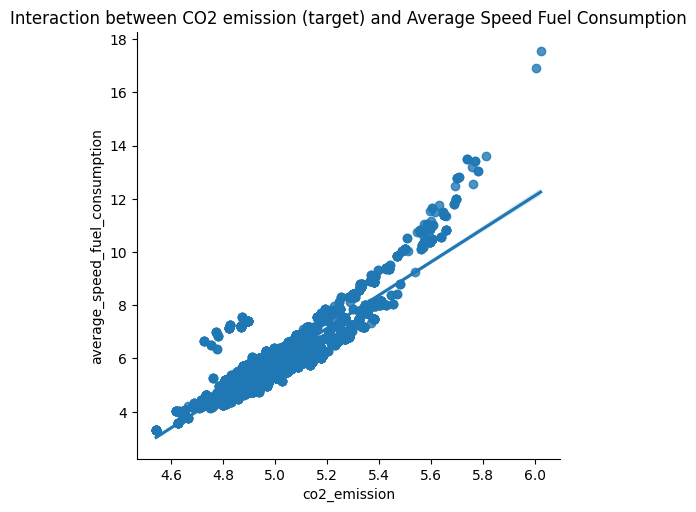

In [26]:
# plot interaction between target and most important correlation variable
sns.lmplot(
    data=df,
    x="co2_emission",
    y="average_speed_fuel_consumption"
    )
plt.title("Interaction between CO2 emission (target) and Average Speed Fuel Consumption")
plt.show()

#### 2. Relation between target and categorical variables

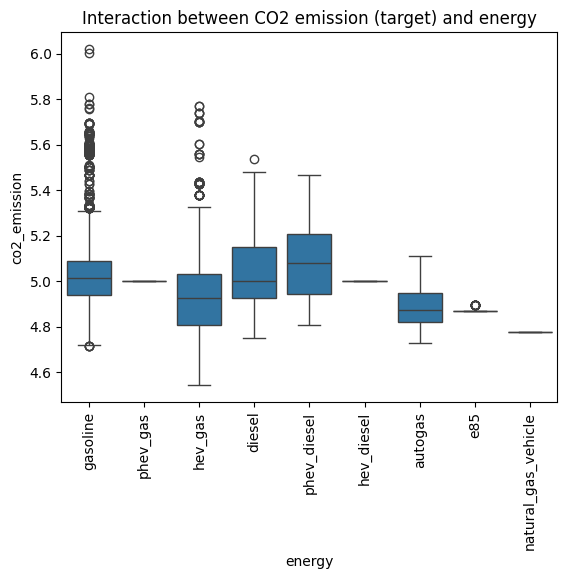

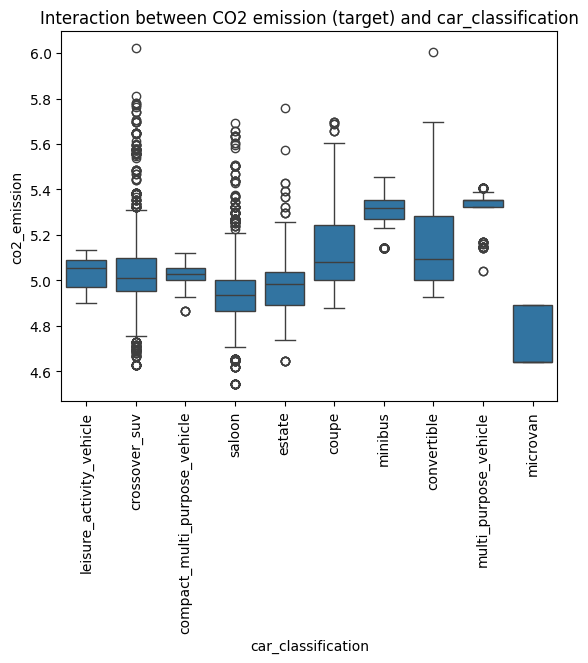

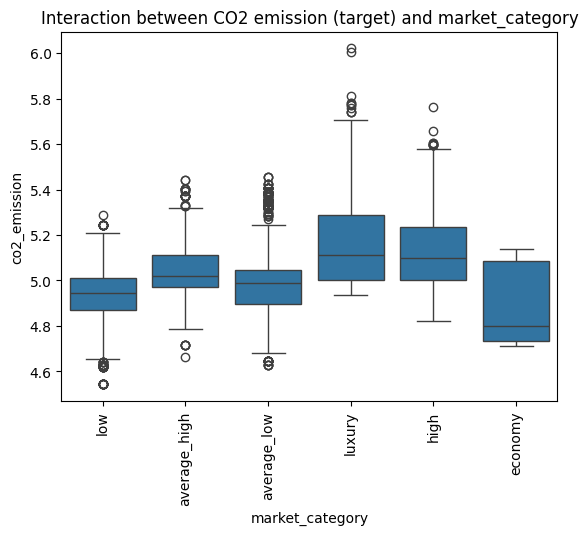

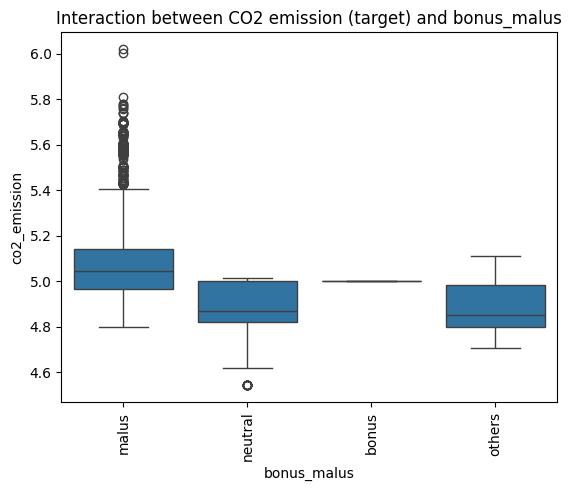

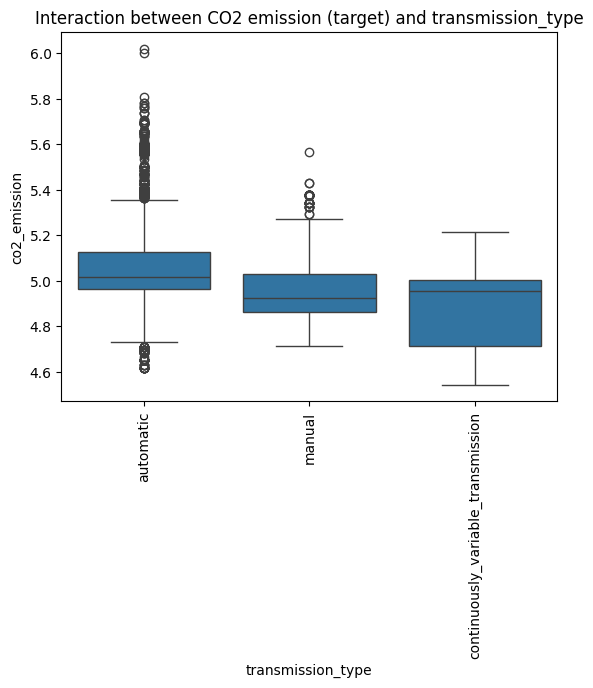

In [27]:
for col in ['energy', 'car_classification', 'market_category', 'bonus_malus', "transmission_type"]:
    sns.boxplot(
        data=df,
        x=col, 
        y="co2_emission"
        )
    plt.title(f"Interaction between CO2 emission (target) and {col}")
    plt.xticks(rotation=90)
    plt.show()

## 3) Modelisation

### a) Data Preparation

- Split data in different sets

In [28]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [29]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_train = df_train["co2_emission"].values
y_val = df_val["co2_emission"].values
y_test = df_test["co2_emission"].values

In [31]:
del df_train['co2_emission']
del df_val['co2_emission']
del df_test['co2_emission']

In [32]:
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'co2_emission'

- DictVectorizer

In [33]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [34]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [35]:
dv.get_feature_names_out()

array(['average_speed_fuel_consumption', 'bonus_malus=bonus',
       'bonus_malus=malus', 'bonus_malus=neutral', 'bonus_malus=others',
       'car_classification=compact_multi_purpose_vehicle',
       'car_classification=convertible', 'car_classification=coupe',
       'car_classification=crossover_suv', 'car_classification=estate',
       'car_classification=leisure_activity_vehicle',
       'car_classification=microvan', 'car_classification=minibus',
       'car_classification=multi_purpose_vehicle',
       'car_classification=saloon', 'combined_speed_fuel_consumption',
       'cylinder_capacity', 'energy=autogas', 'energy=diesel',
       'energy=e85', 'energy=gasoline', 'energy=hev_diesel',
       'energy=hev_gas', 'energy=natural_gas_vehicle',
       'energy=phev_diesel', 'energy=phev_gas',
       'high_speed_fuel_consumption', 'low_speed_fuel_consumption',
       'make=alfa_romeo', 'make=alpine', 'make=audi', 'make=b.m.w.',
       'make=bentley', 'make=citroen', 'make=cupra', 'mak

### b) Baseline model

In [36]:
# dummy model which predicts median value each times
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [37]:
y_pred = dummy.predict(X_val)

In [38]:
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 0.17489


In [39]:
del y_pred
del rmse
gc.collect()

86349

### b) Linear Model

In [40]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [41]:
y_pred = lr.predict(X_val)

In [42]:
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 110431.04789


In [43]:
del y_pred
del rmse
gc.collect()

32488

- Tune with rigde regression

In [44]:
# testing different alpha
# alpha correspond to the regularization strength
alpha = [0.001, 0.01, 0.1, 1, 10]

for value in alpha:
    ridge = Ridge(alpha=value,
                  random_state=42)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
    print(f"alpha: {value} -> rmse: {rmse}")

alpha: 0.001 -> rmse: 0.02577
alpha: 0.01 -> rmse: 0.02577
alpha: 0.1 -> rmse: 0.02576
alpha: 1 -> rmse: 0.02571
alpha: 10 -> rmse: 0.02755


In [45]:
ridge = Ridge(alpha = 10,
              random_state=42)

### c) Decision Tree

In [46]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [47]:
y_pred = dt.predict(X_val)

In [48]:
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 0.01071


In [49]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- average_speed_fuel_consumption <= 6.67
|   |--- average_speed_fuel_consumption <= 5.28
|   |   |--- average_speed_fuel_consumption <= 4.63
|   |   |   |--- max_horsepower <= 79.10
|   |   |   |   |--- average_speed_fuel_consumption <= 4.12
|   |   |   |   |   |--- high_speed_fuel_consumption <= 3.96
|   |   |   |   |   |   |--- weight <= 1127.50
|   |   |   |   |   |   |   |--- model=yaris <= 0.50
|   |   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |   |--- model=yaris >  0.50
|   |   |   |   |   |   |   |   |--- weight <= 1087.50
|   |   |   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |   |   |--- weight >  1087.50
|   |   |   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |--- weight >  1127.50
|   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |--- high_speed_fuel_consumption >  3.96
|   |   |   |   |   |   |--- combined_speed_fuel_consumption <= 4.62
|   |   |   |   |   |   |   |--- average_speed

- Tuning DecisionTree

In [50]:
# testing max_depth
max_depth = [2, 4, 6, 8, 10, 15]

for d in max_depth:
    dt = DecisionTreeRegressor(
        max_depth=d,
        random_state=42
    )
    
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
    print(f"max_depth: {d}; rmse: {rmse}")

max_depth: 2; rmse: 0.09273
max_depth: 4; rmse: 0.04434
max_depth: 6; rmse: 0.02438
max_depth: 8; rmse: 0.01381
max_depth: 10; rmse: 0.01062
max_depth: 15; rmse: 0.00994


In [51]:
# testing max_depth and min_sample_leaf
scores = []

max_depth = [9, 10, 11, 12, 15]
min_sample_leaf = [1, 3, 5, 8, 10, 15, 20, 500, 100, 200]

for d in max_depth:
    for s in min_sample_leaf:
        dt = DecisionTreeRegressor(
            max_depth = d,
            min_samples_leaf=s,
            random_state=42
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        
        rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
        scores.append((d, s, rmse))

In [52]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_sample_leaf', 'rmse'])

In [53]:
df_scores.sort_values(by="rmse", ascending=False)
df_scores.head()

,max_depth,min_sample_leaf,rmse
0,9,1,0.01177
1,9,3,0.01347
2,9,5,0.01486
3,9,8,0.01702
4,9,10,0.01807


In [54]:
dt = DecisionTreeRegressor(max_depth=9,
                           min_samples_leaf=1,
                           random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=42)

In [55]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- average_speed_fuel_consumption <= 6.67
|   |--- average_speed_fuel_consumption <= 5.28
|   |   |--- average_speed_fuel_consumption <= 4.63
|   |   |   |--- max_horsepower <= 79.10
|   |   |   |   |--- average_speed_fuel_consumption <= 4.12
|   |   |   |   |   |--- high_speed_fuel_consumption <= 3.96
|   |   |   |   |   |   |--- weight <= 1127.50
|   |   |   |   |   |   |   |--- model=yaris <= 0.50
|   |   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |   |--- model=yaris >  0.50
|   |   |   |   |   |   |   |   |--- weight <= 1087.50
|   |   |   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |   |   |--- weight >  1087.50
|   |   |   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |--- weight >  1127.50
|   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |--- high_speed_fuel_consumption >  3.96
|   |   |   |   |   |   |--- combined_speed_fuel_consumption <= 4.62
|   |   |   |   |   |   |   |--- make=renault 

In [56]:
del y_pred
del rmse
gc.collect()

491

### d) Random Forest

In [57]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [58]:
y_pred = rf.predict(X_val)

In [59]:
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 0.00972


- Tuning RandomForest

In [60]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=42,
        n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
    scores.append((n, rmse))

In [61]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [62]:
df_scores

,n_estimators,rmse
0,10,0.00993
1,20,0.01074
2,30,0.01086
3,40,0.01070
4,50,0.01052
5,60,0.01067
6,70,0.01036
7,80,0.01014
8,90,0.00985
9,100,0.00972


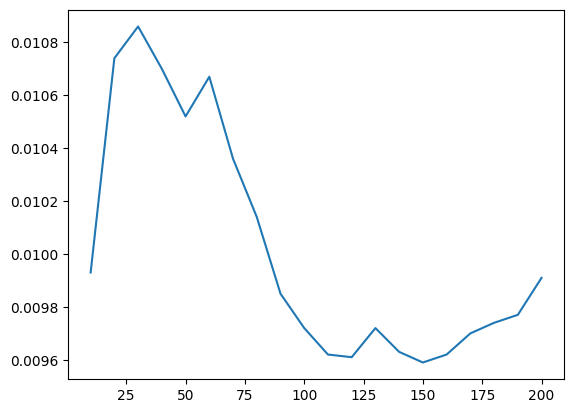

In [63]:
plt.plot(df_scores["n_estimators"], df_scores["rmse"])

In [64]:
del scores
del df_scores
gc.collect()

75

In [65]:
# testing different max_depth & n_estimators
scores = []

max_depth = [8, 9, 10]

for n in range(10, 201, 10):
    for d in max_depth:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth = d,
            random_state=42,
            n_jobs = -1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        
        rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
        scores.append((n, d, rmse))

In [66]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])

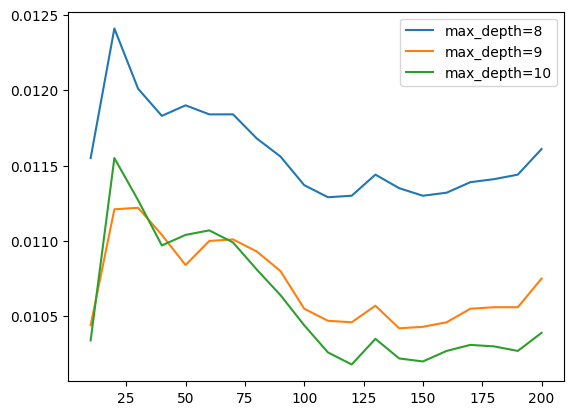

In [67]:
for d in max_depth:
    df_subset = df_scores[df_scores["max_depth"] == d]
    
    plt.plot(df_subset["n_estimators"], df_subset["rmse"],
             label='max_depth=%d' % d)

plt.legend()

In [68]:
max_depth = 10

In [69]:
# testing different max_depth, min_samples_leaf & n_estimators
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42,
                                    bootstrap=True,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)

        scores.append((s, n, rmse))

In [70]:
columns = ['min_samples_leaf', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

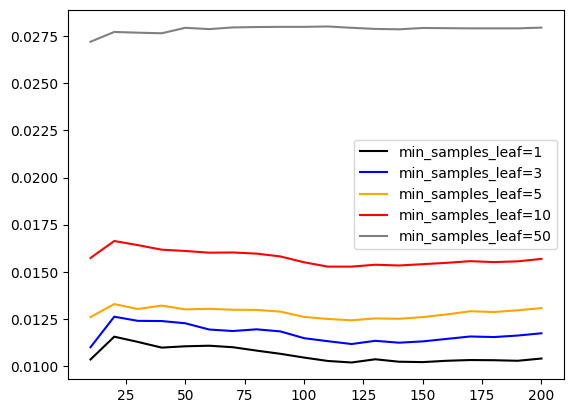

In [71]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset["n_estimators"], df_subset["rmse"],
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [72]:
max_depth = 10
n_estimators = 150
min_sample_leaf = 1

In [73]:
rf = RandomForestRegressor(
    max_depth=max_depth,
    n_estimators=n_estimators,
    min_samples_leaf=min_sample_leaf,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=150, n_jobs=-1,
                      random_state=42)

In [74]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending=False).head(10)

,feature,importance
0,average_speed_fuel_consumption,0.674928
334,weight,0.115877
15,combined_speed_fuel_consumption,0.067828
26,high_speed_fuel_consumption,0.044484
2,bonus_malus=malus,0.027983
27,low_speed_fuel_consumption,0.019157
16,cylinder_capacity,0.019054
3,bonus_malus=neutral,0.009689
333,very_high_speed_fuel_consumption,0.006672
72,max_horsepower,0.003314


In [75]:
y_pred = rf.predict(X_val)

In [76]:
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 0.0102


In [77]:
del y_pred
del rmse
gc.collect()

575

### e) XGBoost

In [78]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [79]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 3,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [80]:
y_pred = model.predict(dval)

In [81]:
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 0.01294


- Tuning XGBoost

1. eta

In [82]:
scores = {}

In [83]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [84]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [85]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [86]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [87]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [88]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [89]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [90]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [91]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

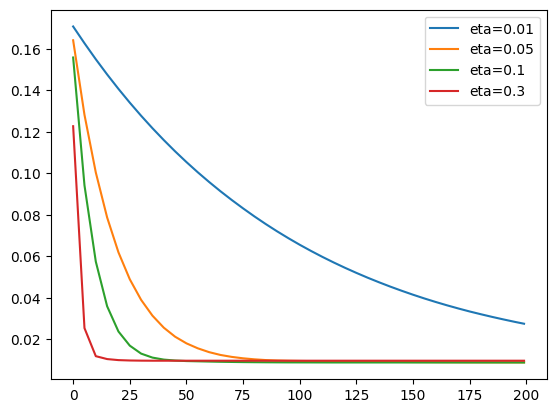

In [92]:
etas = scores.keys()

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score["num_iter"], df_score["val_mse"], label=eta)
plt.legend()

In [93]:
eta = 0.3

2. max_depth

In [94]:
scores = {}

In [95]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [96]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

In [97]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [98]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

In [99]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 9,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [100]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

In [101]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [102]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

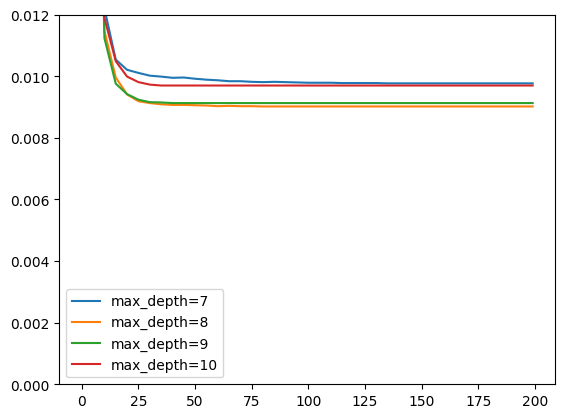

In [103]:
max_depth = scores.keys()

for max in max_depth:
    df_score = scores[max]
    plt.plot(df_score["num_iter"], df_score["val_mse"], label=max)
    plt.ylim([0, 0.012])
plt.legend()

In [104]:
max_depth = 8

3. min_child_weight

In [105]:
scores = {}

In [106]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [107]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [108]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 3,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [109]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [110]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 5,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [111]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [112]:
%%capture output

xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 8,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=200)

In [113]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

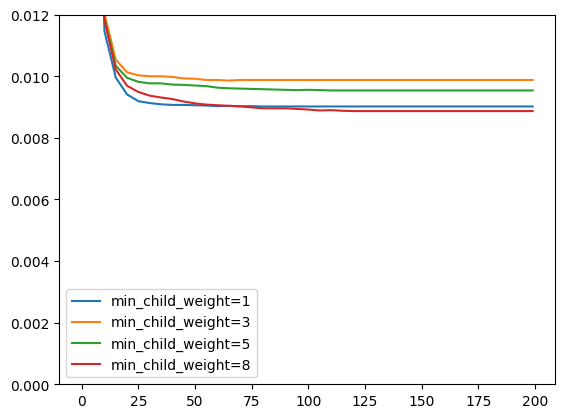

In [114]:
min_child_weight = scores.keys()

for value in min_child_weight:
    df_score = scores[value]
    plt.plot(df_score["num_iter"], df_score["val_mse"], label=value)
    plt.ylim([0, 0.012])
    
plt.legend()

In [115]:
min_child_weight = 8

- Final model

In [116]:
xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=50)

## 4) Evaluation on test sets

In [117]:
y_full_train = df_full_train["co2_emission"].values

In [118]:
del df_full_train["co2_emission"]

In [119]:
full_train_dicts = df_full_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [120]:
X_full_train = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)

In [121]:
final_eval = []

model = [dummy, ridge, dt, rf]
for model in model:
    model.fit(X_full_train, y_full_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test)).round(5)
    mape = mean_absolute_percentage_error(y_pred, y_test).round(5)
    final_eval.append((rmse, mape))

In [122]:
df_eval = pd.DataFrame(final_eval, 
                       index=["Dummy", "Ridge", "DecisionTree", "RandomForest"],
                       columns=["rmse", "mape"])

In [123]:
df_eval

,rmse,mape
Dummy,0.17302,0.02382
Ridge,0.02399,0.00276
DecisionTree,0.00698,0.00074
RandomForest,0.00436,0.00031


In [124]:
features = list(dv.get_feature_names_out())
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [125]:
model = xgb.train(xgb_params, dfulltrain, num_boost_round=50)

In [126]:
y_pred = model.predict(dtest)

In [127]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
print(f"rmse: {rmse}")

rmse: 0.00584


In [128]:
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"mape: {mape}")

mape: 0.00039
